In [1]:
import cellrank as cr
import scanpy as sc
import scvelo as sv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [3]:
datasets = ['Pancreas_with_cc', 'DentateGyrus' , 'MouseBoneMarrow', 'MouseErythroid', 'HumanBoneMarrow']
methods = ['cell2fate', 'scvelo']

In [4]:
i = 1
j = 0
# Load data
adata = sc.read_h5ad('/nfs/team283/aa16/data/fate_benchmarking/CellRank/' + methods[j] + datasets[i] + 'AnnDataForCellRank.h5ad')

In [5]:
relevant_clusters = np.array(('Neuroblast', 'Granule mature', 'Granule immature'))

In [6]:
adata = adata[np.array([x in relevant_clusters for x in np.array(adata.obs['clusters'])]),:]

In [7]:
adata.X = adata.layers['unspliced'] + adata.layers['spliced']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 5000, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.pp.neighbors(adata)

In [8]:
adata = sc.tl.leiden(adata, resolution = 0.75, copy = True)

In [9]:
adata.obs['age(days)'].value_counts()

age(days)
35    1443
12     829
Name: count, dtype: int64

In [10]:
adata.obs['Real Time'] = [float(x)*24 for x in adata.obs['age(days)']]

In [11]:
adata.obs['Age of Cells'] = [str(int(float(x)*24)) for x in adata.obs['age(days)']]

In [12]:
real_time = []
inferred_time = []
clusters = [str(x) for x in np.unique([int(x) for x in adata.obs['leiden']])]
for i in range(len(clusters)):
    real_time += [np.mean(adata.obs['Real Time'][adata.obs['leiden'] == clusters[i]])]
    inferred_time += [np.mean(adata.obs['Time (hours)'][adata.obs['leiden'] == clusters[i]])]

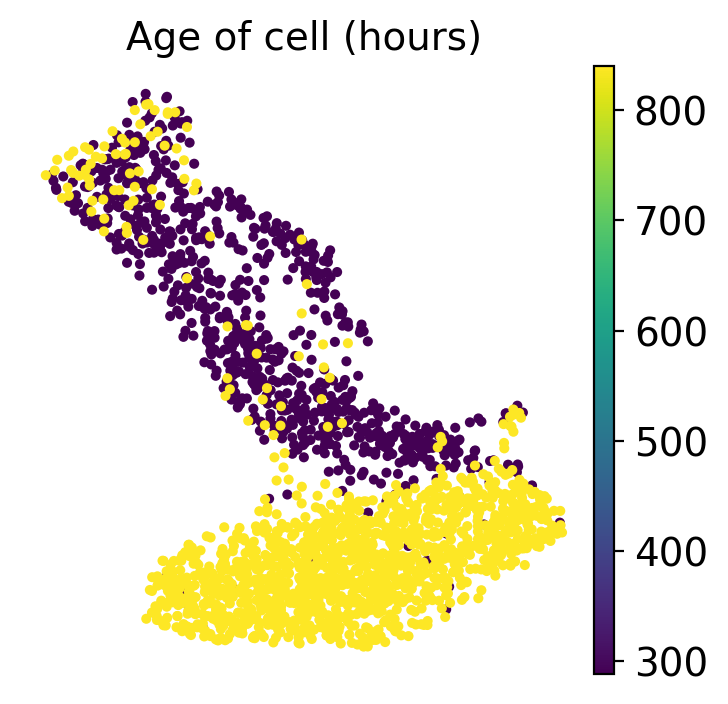

In [13]:
sc.pl.umap(adata, color = ['Real Time'], title = 'Age of cell (hours)')

In [14]:
colors = ['indigo', 'gold']

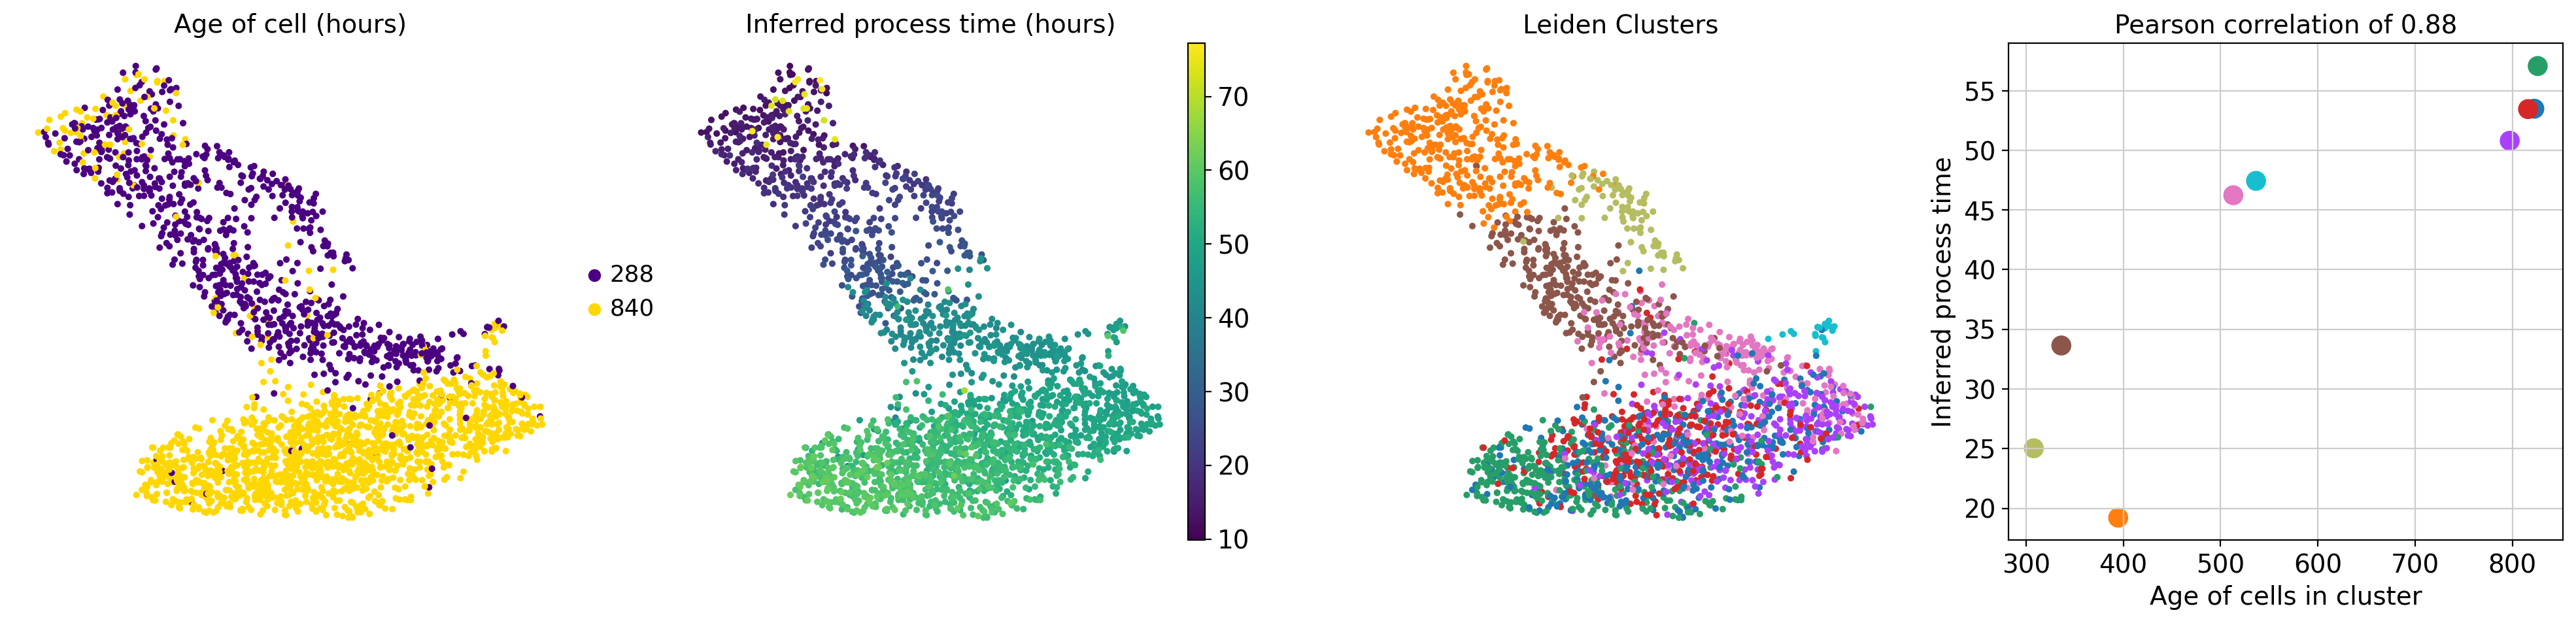

In [15]:
fig, ax = plt.subplots(1,4, figsize = (25,5))
sc.pl.umap(adata, color = ['Age of Cells'], ax = ax[0], show = False, title = 'Age of cell (hours)', palette = colors)
sc.pl.umap(adata, color = ['Time (hours)'], ax = ax[1], show = False, title = 'Inferred process time (hours)')
sc.pl.umap(adata, color = ['leiden'], ax = ax[2], show = False, title = 'Leiden Clusters', legend_loc = None)
ax[3].scatter(real_time, inferred_time, color = adata.uns['leiden_colors'], s = 100)
ax[3].set_title('Pearson correlation of 0.88')
ax[3].set_xlabel('Age of cells in cluster')
ax[3].set_ylabel('Inferred process time')
fig.savefig('/nfs/team283/aa16/data/fate_benchmarking/GranuleNeuronTimeComparison_v2.pdf')

In [16]:
np.corrcoef(inferred_time, real_time)

array([[1.        , 0.88190234],
       [0.88190234, 1.        ]])